# Hidden Markov Models (HMMs)

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (15, 5)
%config InlineBackend.figure_format = 'retina'

# 2-State (Closed $\rightleftarrows$ Open) HMM for an ion channel

### Starting probability in each state:

In [2]:
p0 = np.array([0.5, 0.5])  # P(C), P(O)

### Transition probabilities per time step:

In [3]:
trans = np.array([[0.95, 0.05],   # P(C->C), P(C->O)
                  [0.15, 0.85]])  # P(O->C), P(O->O)

### Emission (i.e. ionic current) distributions for each state:

In [4]:
emis = [st.norm(0, 1), st.norm(5, 1)]  # closed, open current distributions

# HMM Simulation

In [5]:
def simulateHMM(p0, trans, emis, numSamples, rseed=0):
    numStates = len(p0)
    stateIds = np.arange(numStates)  # 0, 1, ..., numStates-1
    
    # preallocate simulation arrays
    stateSequence = np.zeros(numSamples, dtype=int)
    observationSequence = np.zeros(numSamples)
    
    # reset pseudo random number generator
    np.random.seed(rseed)
    
    # randomly assign starting state
    stateSequence[0] = np.random.choice(stateIds, p=p0)
    
    # randomly assign subsequent states based on the transition probabilities
    for t in range(numSamples-1):
        state = stateSequence[t]
        stateSequence[t+1] = np.random.choice(stateIds, p=trans[state,:])
    
    # randomly draw state observations from emission distributions
    for state in stateIds:
        stateMask = (stateSequence == state)
        observationSequence[stateMask] = emis[state].rvs(stateMask.sum())
    
    return stateSequence, observationSequence

In [6]:
stateSeq, observationSeq = simulateHMM(p0, trans, emis, 1000)

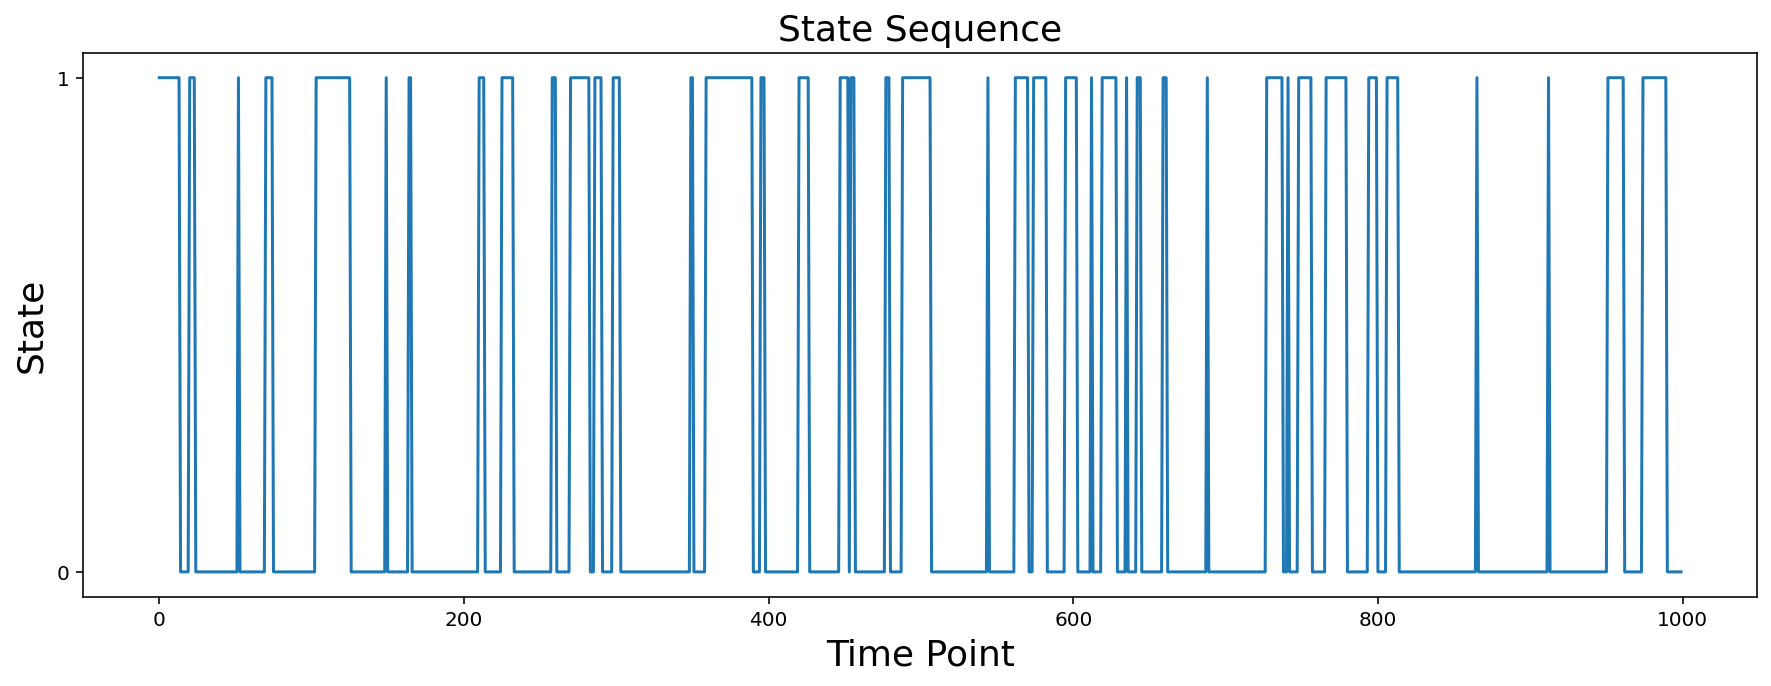

In [7]:
plt.plot(stateSeq)
plt.yticks(np.unique(stateSeq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

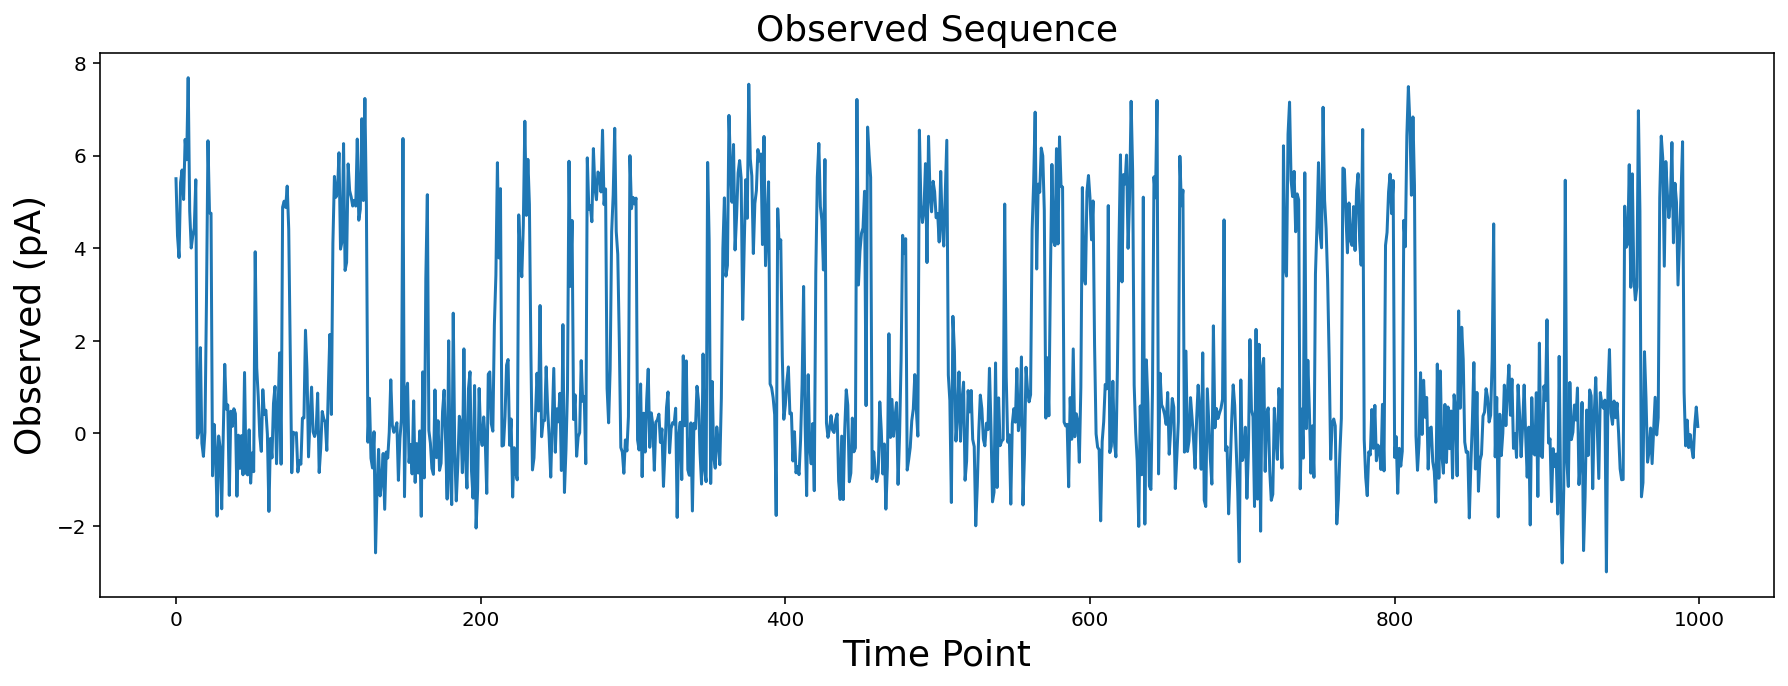

In [8]:
plt.plot(observationSeq)
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence');

# Threshold Idealization of Observations

In [9]:
threshold = 2.5
predictedStateSeq = np.zeros(observationSeq.shape, dtype=int)
predictedStateSeq[observationSeq < threshold] = 0
predictedStateSeq[observationSeq >= threshold] = 1

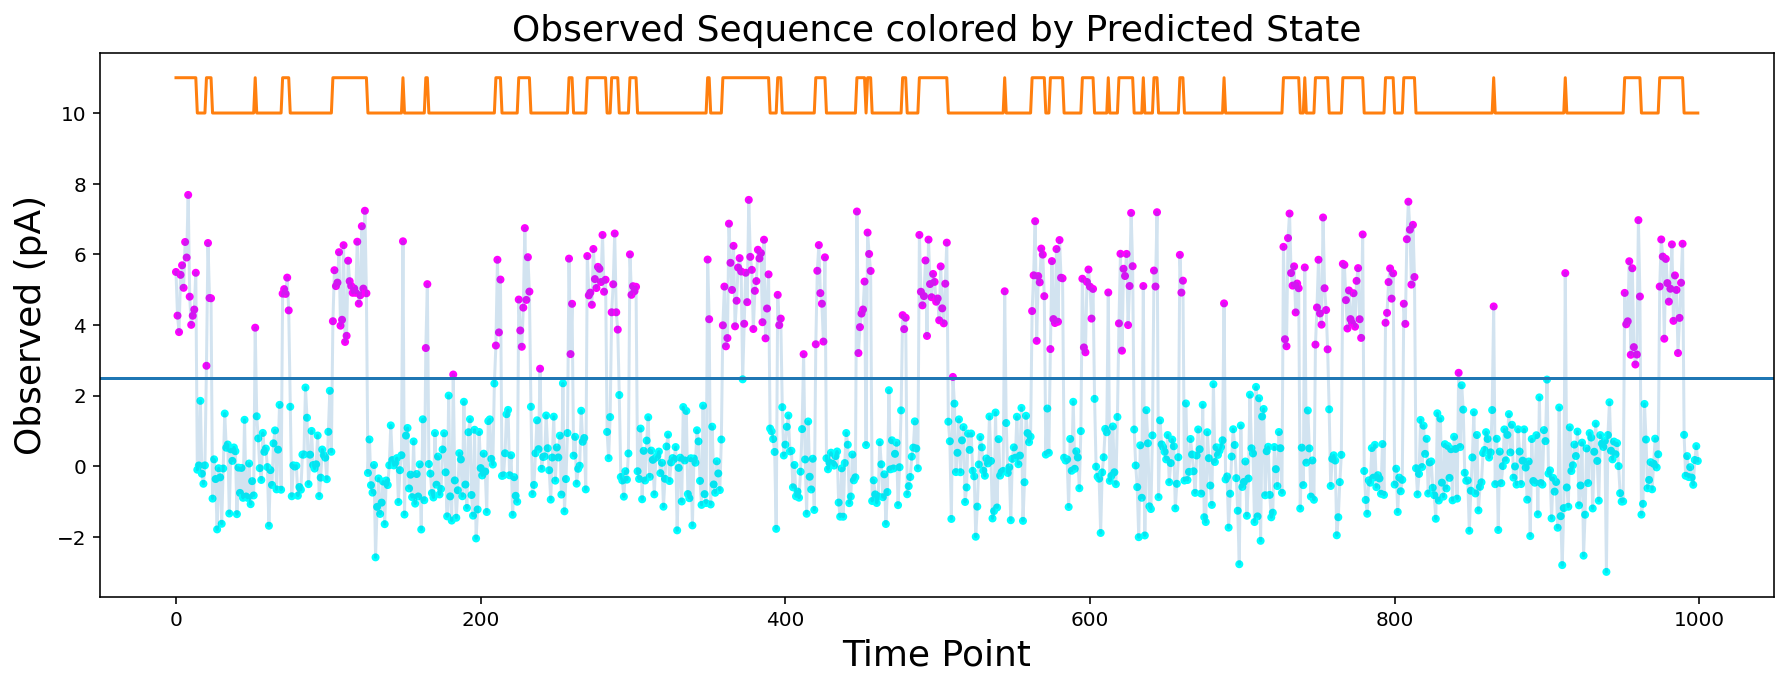

In [10]:
plt.plot(observationSeq, alpha=0.2)
plt.scatter(range(len(observationSeq)), observationSeq, marker='.', c=predictedStateSeq, cmap='cool')
plt.axhline(threshold)
plt.plot(stateSeq + 10)
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence colored by Predicted State');

### <font color=red> How well did thresholding do?</font>

### <font color=red> Can you think of a case where thresholding won't work well?</font>

Other clustering methods such as GMMs, kmeans, etc. can also classify states by amplitude.

We'll explore some of these later in the semester.

## <font color=red> However, amplitude clustering can NOT:</font>

* distinguish states with identical or very similar emissions
* distinguish between a random large noise fluctuation and a transition

## <font color=blue>HMMs can do this.</font>

# Filtering and Missed Events

In [11]:
dt_ms = 0.1
fs_kHz = 1 / dt_ms
time_ms = np.arange(len(observationSeq)) * dt_ms
current_pA = observationSeq

In [12]:
from scipy import signal

lowpass2kHz = signal.firwin(301, 2, nyq=fs_kHz/2)
lowpass1kHz = signal.firwin(301, 1, nyq=fs_kHz/2)

filtered2kHz = np.convolve(current_pA, lowpass2kHz, 'same')
filtered1kHz = np.convolve(current_pA, lowpass1kHz, 'same')

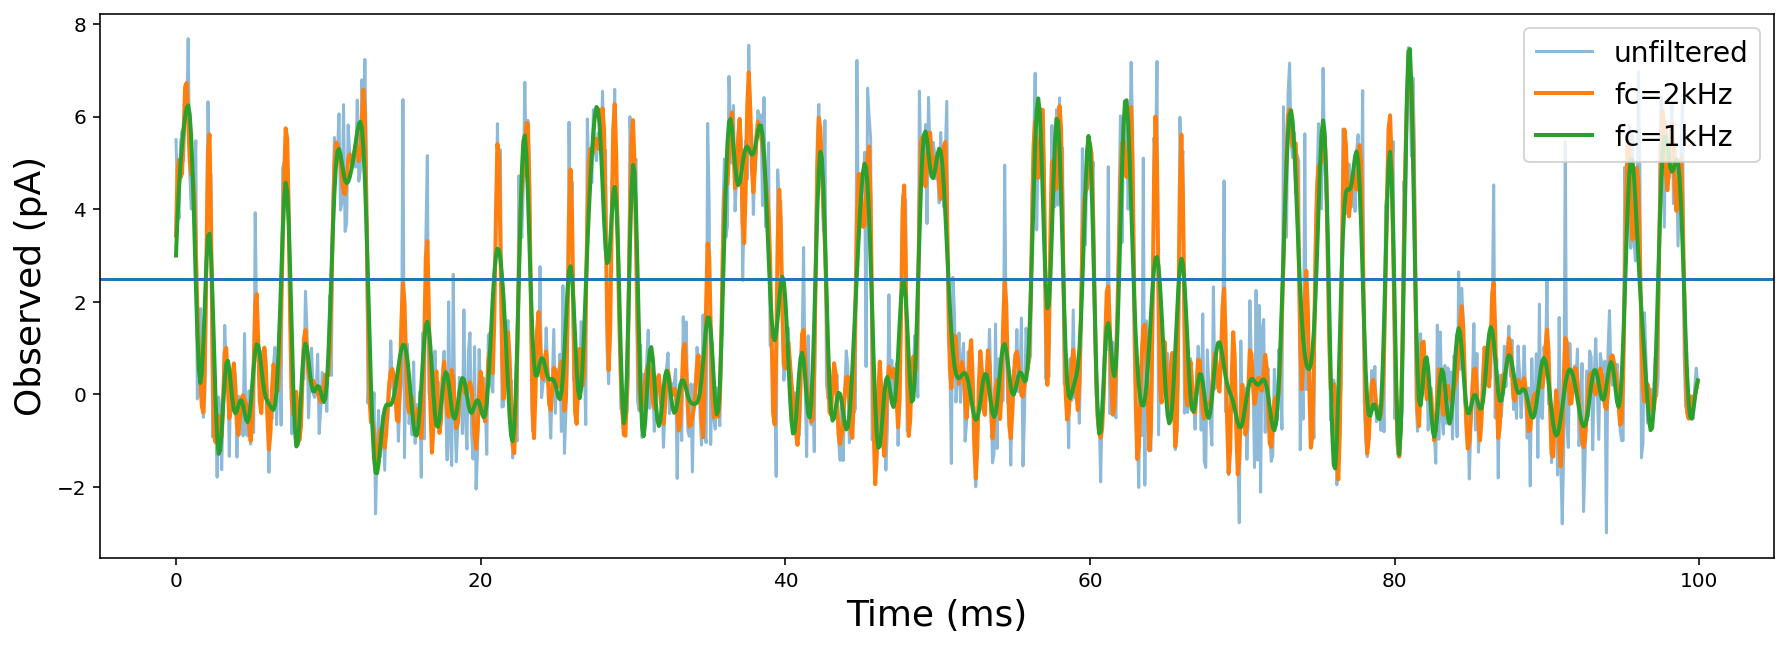

In [13]:
plt.plot(time_ms, current_pA, alpha=0.5, label='unfiltered')
plt.plot(time_ms, filtered2kHz, lw=2, label='fc=2kHz')
plt.plot(time_ms, filtered1kHz, lw=2, label='fc=1kHz')
plt.axhline(threshold)
plt.xlabel('Time (ms)')
plt.ylabel('Observed (pA)');
plt.legend();

### <font color=red> Examine the plot and see if you can think of a pro and a con of filtering.</font>

# 3-State (Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized) HMM for an ion channel

### Starting probability in each state:

In [14]:
p0 = np.array([1, 0, 0])  # P(C), P(O), P(D)

### Transition probabilities per time step:

In [15]:
trans = np.array([[0.950, 0.050, 0.000],   # P(C->C), P(C->O), P(C->D)
                  [0.030, 0.950, 0.020],   # P(O->C), P(O->O), P(O->D)
                  [0.000, 0.004, 0.996]])  # P(D->C), P(D->O), P(D->D)

### Emission (i.e. ionic current) distributions for each state:

In [16]:
emis = [st.norm(0, 1), st.norm(5, 1), st.norm(0, 1)]

### Simulate some data for the HMM:

In [17]:
stateSeq, current_pA = simulateHMM(p0, trans, emis, 100000)

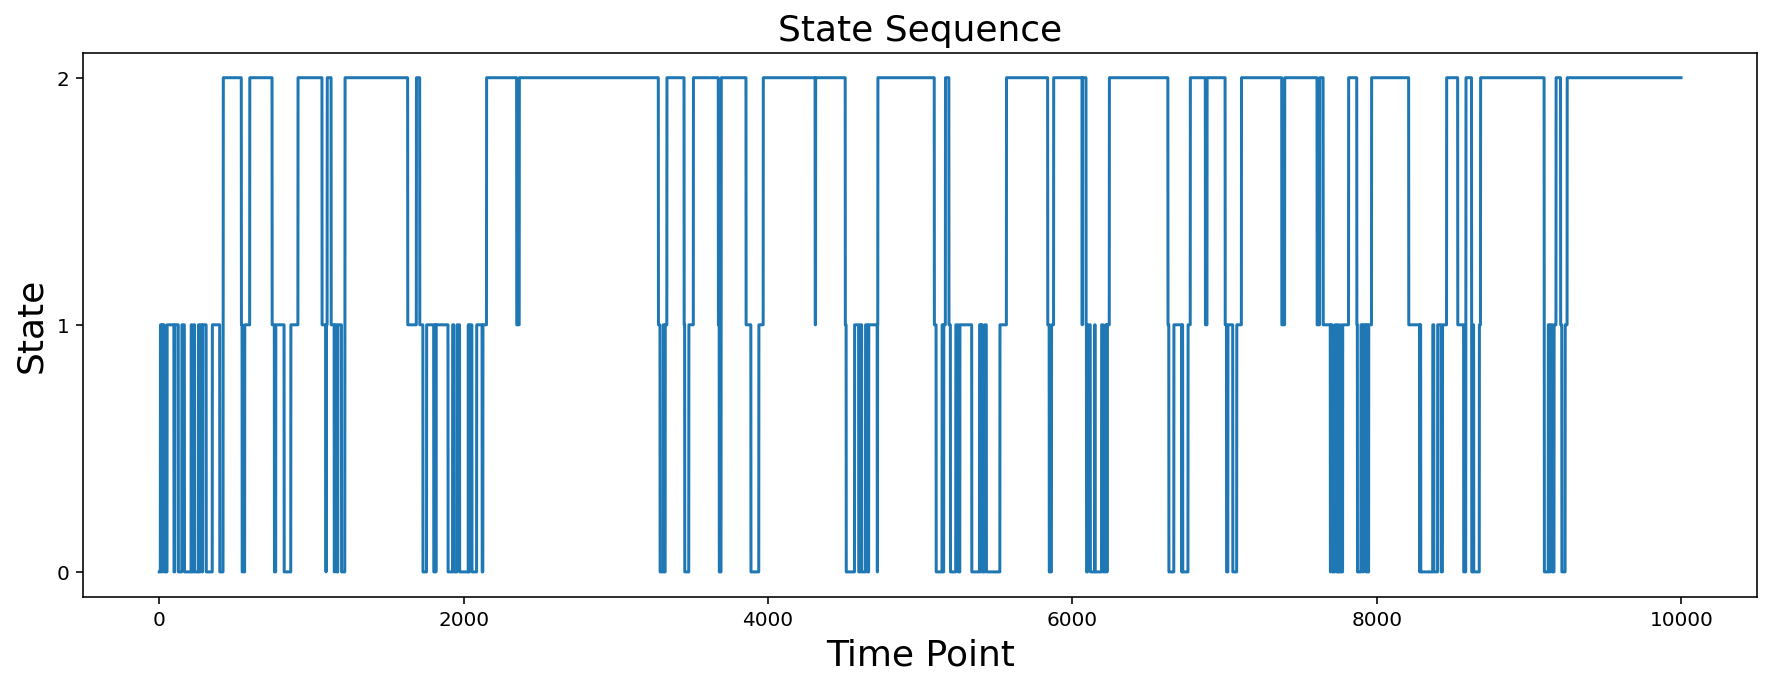

In [18]:
n = 10000
plt.plot(stateSeq[:n])
plt.yticks(np.unique(stateSeq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

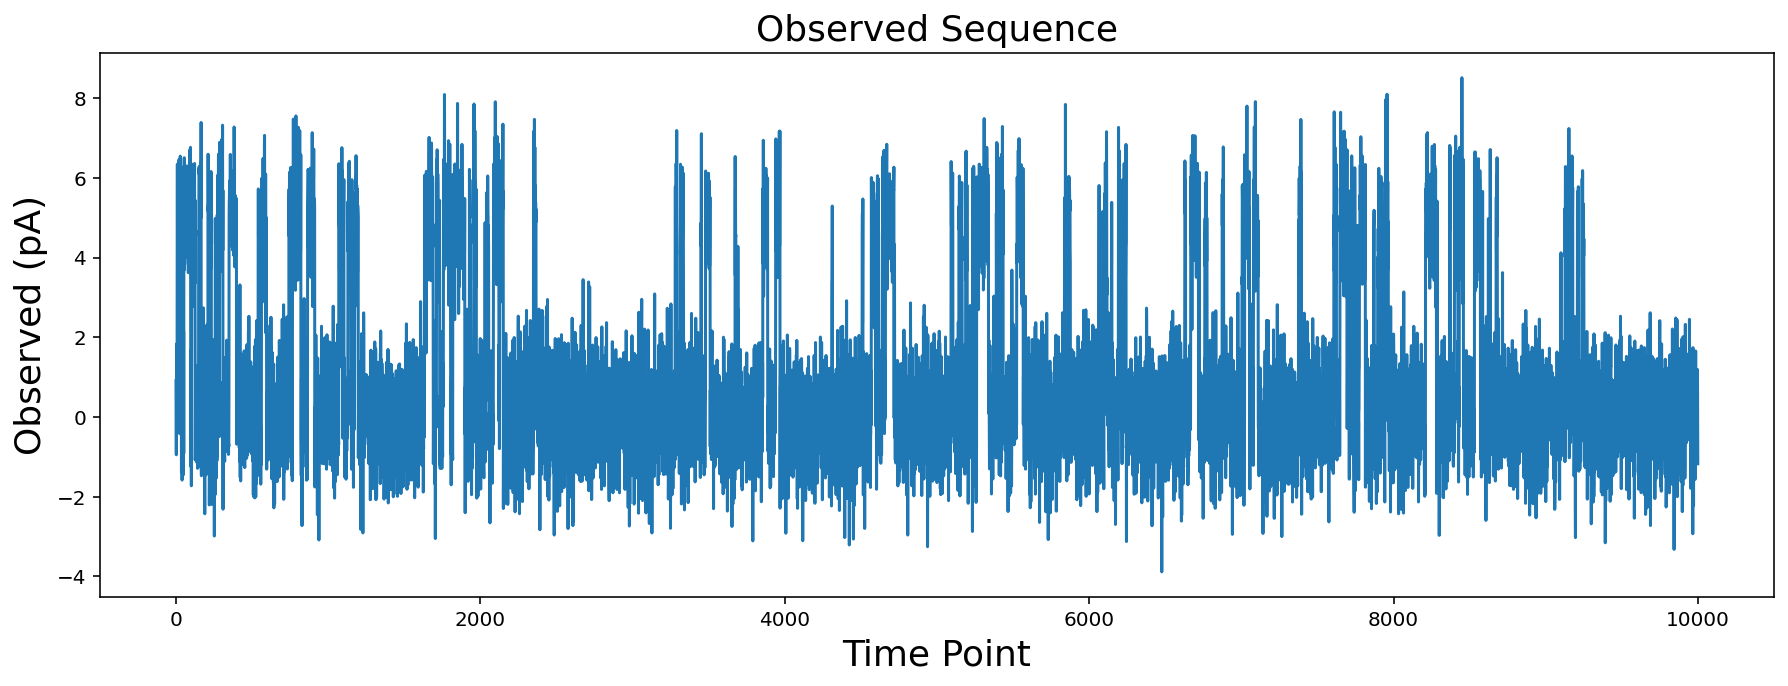

In [19]:
n = 10000
plt.plot(current_pA[:n])
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence');

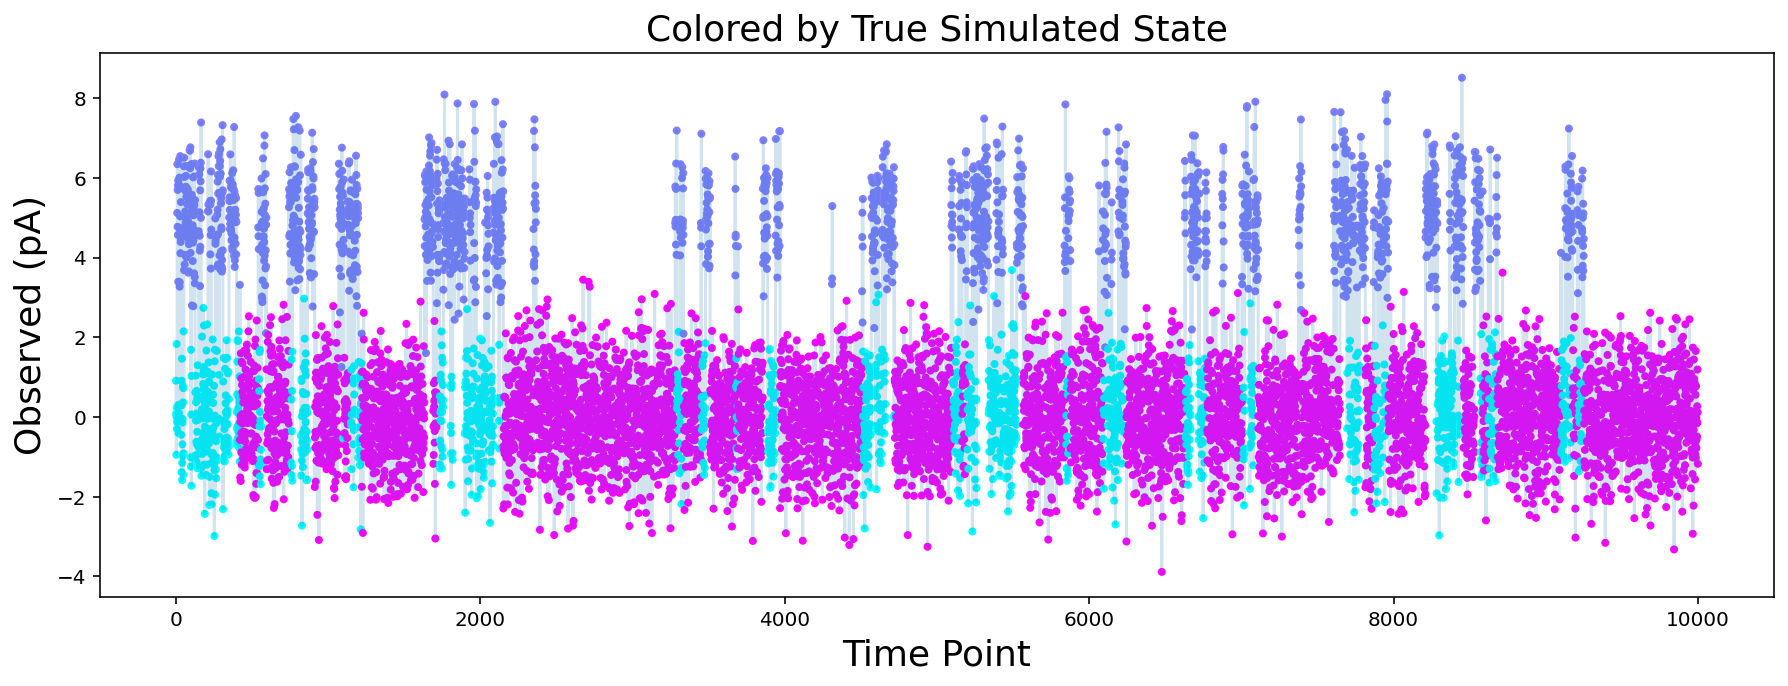

In [20]:
n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=stateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by True Simulated State');

### <font color=red>How might you distinguish between the closed and desensitized states?</font>

# Dwell Time Distributions

Examination of these distributions can suggest how many states at each emission level you should include in your model.

In [21]:
dwelltimes = {}
for i in np.unique(stateSeq):
    dwelltimes[i] = []
for i, state in enumerate(stateSeq):
    if i > 0 and stateSeq[i-1] == state:
        dwelltimes[state][-1] += 1
    else:
        dwelltimes[state].append(1)

closedTimes = dwelltimes[0] + dwelltimes[2]
openTimes = dwelltimes[1]

dt_ms = 0.1
closedTimes_ms = np.array(closedTimes) * dt_ms
openTimes_ms = np.array(openTimes) * dt_ms

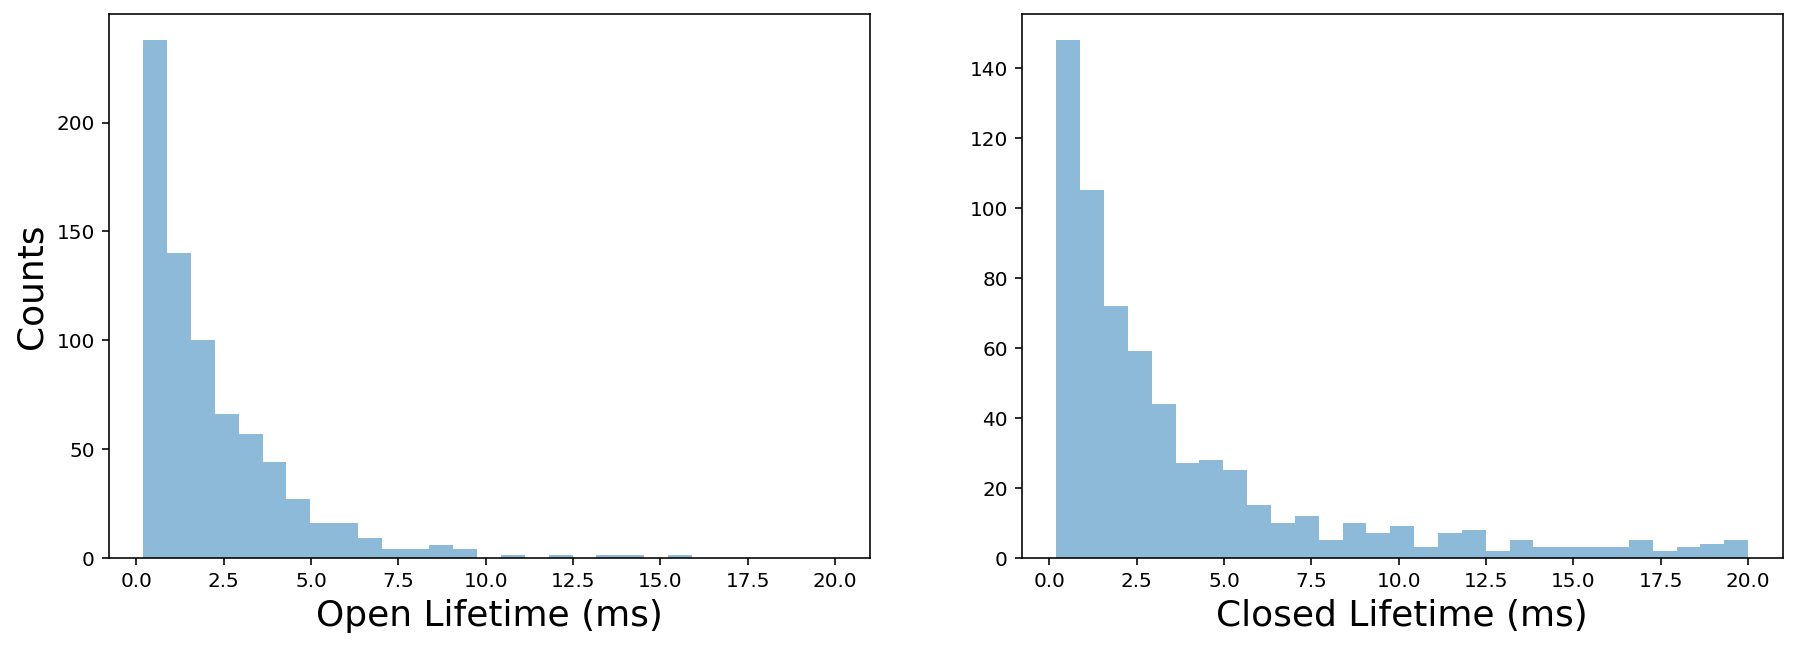

In [22]:
plt.subplot(121)
binedges = np.linspace(0.2, 20, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Open Lifetime (ms)')
plt.ylabel('Counts')

plt.subplot(122)
binedges = np.linspace(0.2, 20, 30)
plt.hist(closedTimes_ms, binedges, alpha=0.5)
plt.xlabel('Closed Lifetime (ms)');

### Dwelltimes are often binned and plotted on a logscale.

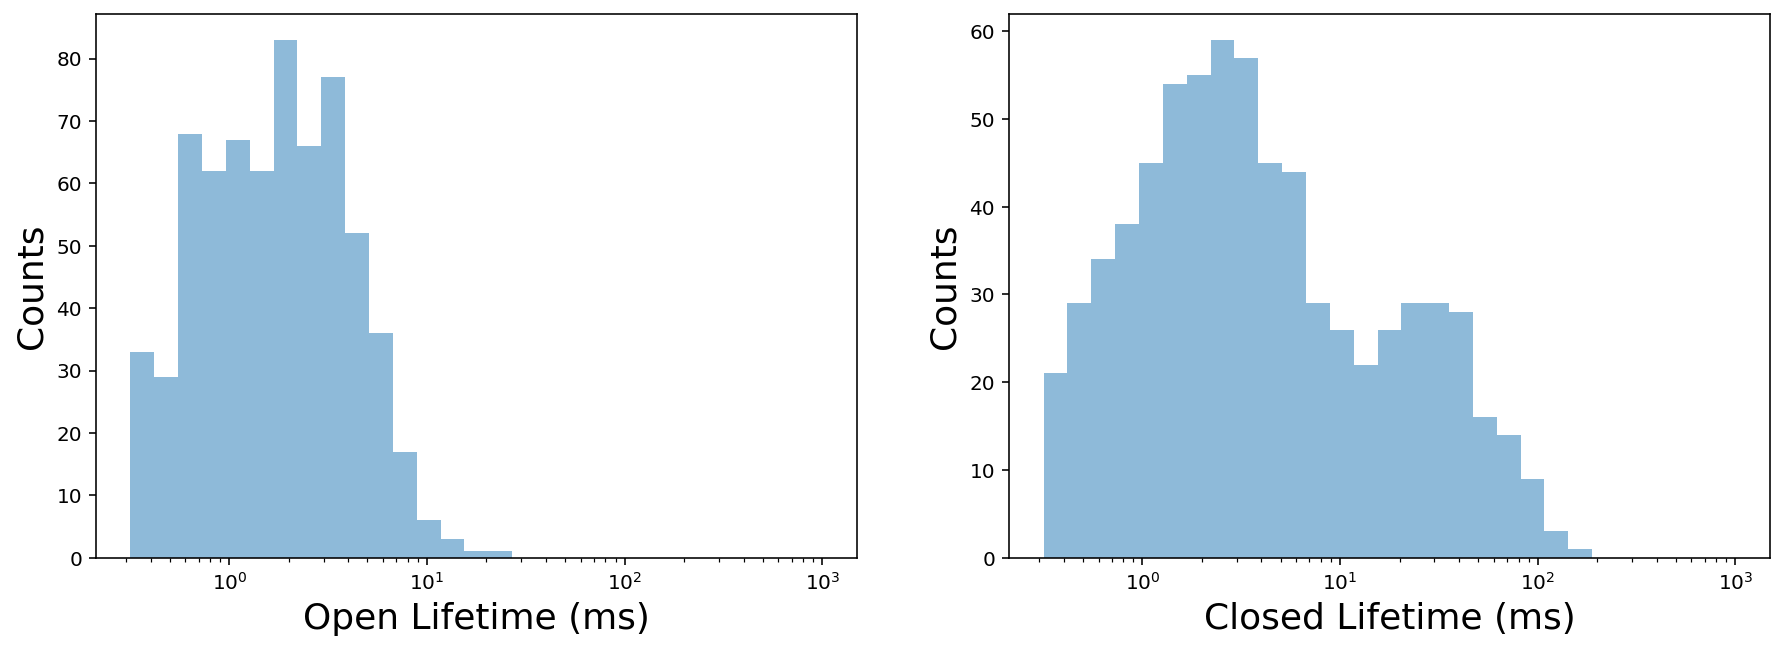

In [23]:
plt.subplot(121)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Open Lifetime (ms)')
plt.ylabel('Counts')
plt.xscale('log')

plt.subplot(122)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(closedTimes_ms, binedges, alpha=0.5)
plt.xlabel('Closed Lifetime (ms)')
plt.ylabel('Counts')
plt.xscale('log');

# Observtions $\rightarrow$ HMM

### Install the pomegranate module

Run the following command in a terminal:

    conda install pomegranate=0.14.3

In [24]:
import pomegranate as pom

### Postulate a HMM to explain the observed current sequence.

In [48]:
hmm = pom.HiddenMarkovModel()

In [49]:
# states
C = pom.State(pom.NormalDistribution(1, 0.8), name='Closed')
O = pom.State(pom.NormalDistribution(7, 1), name='Open')
D = pom.State(pom.NormalDistribution(0, 0.8), name='Desensitized')
hmm.add_states([C, O, D])

In [50]:
# starting probability in each state (MUST add to one)
hmm.add_transition(hmm.start, C, 0.9)
hmm.add_transition(hmm.start, O, 0.1)

In [51]:
# transition probabilites per time step between states
hmm.add_transition(C, C, 0.90)
hmm.add_transition(C, O, 0.10) # sum from C MUST add to one

hmm.add_transition(O, C, 0.05)
hmm.add_transition(O, O, 0.90)
hmm.add_transition(O, D, 0.05) # sum from O MUST add to one

hmm.add_transition(D, O, 0.05)
hmm.add_transition(D, D, 0.95) # sum from D MUST add to one

In [52]:
# we have to bake it before we can use it!
hmm.bake()

### hmm.states

A list of dictionaries (one per state) with info about the HMM.

In [53]:
hmm.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             1.0,
             0.8
         ],
         "frozen" : false
     },
     "name" : "Closed",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             0.0,
             0.8
         ],
         "frozen" : false
     },
     "name" : "Desensitized",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             7.0,
             1.0
         ],
         "frozen" : false
     },
     "name" : "Open",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution"

In [54]:
hmm.states[0]

{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "name" : "NormalDistribution",
        "parameters" : [
            1.0,
            0.8
        ],
        "frozen" : false
    },
    "name" : "Closed",
    "weight" : 1.0
}

In [55]:
hmm.states[0].name

'Closed'

In [56]:
hmmStateNames = [state.name for state in hmm.states]
hmmStateNames

['Closed', 'Desensitized', 'Open', 'None-start', 'None-end']

### !!! Beware, the order of the states may be changed when you bake the HMM.

### Initial HMM parameters in Pandas tables. These are just the values we specified above.

In [57]:
trans = hmm.dense_transition_matrix()
trans

array([[0.9 , 0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.95, 0.05, 0.  , 0.  ],
       [0.05, 0.05, 0.9 , 0.  , 0.  ],
       [0.9 , 0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

In [58]:
import pandas as pd
transdf = pd.DataFrame(trans, index=hmmStateNames, columns=hmmStateNames)
transdf

,Closed,Desensitized,Open,None-start,None-end
Closed,0.90,0.00,0.10,0.0,0.0
Desensitized,0.00,0.95,0.05,0.0,0.0
Open,0.05,0.05,0.90,0.0,0.0
None-start,0.90,0.00,0.10,0.0,0.0
None-end,0.00,0.00,0.00,0.0,0.0


In [59]:
states = ["Closed", "Open", "Desensitized"]
transdf.loc[states, states]

,Closed,Open,Desensitized
Closed,0.90,0.10,0.00
Open,0.05,0.90,0.05
Desensitized,0.00,0.05,0.95


In [60]:
# starting state probabilities
transdf.loc[["None-start"], states]

,Closed,Open,Desensitized
None-start,0.9,0.1,0.0


In [61]:
# state emission ddistribution parameters
emisdf = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=hmmStateNames[:3], columns=['mean', 'std'])
emisdf.loc[states,:]

,mean,std
Closed,1.0,0.8
Open,7.0,1.0
Desensitized,0.0,0.8


### Probability that our initial postulated model explains our observations.

In [62]:
hmm.probability(current_pA)

0.0

In [63]:
hmm.probability(current_pA[:100])  # less points

2.9521649502255903e-123

In [64]:
hmm.log_probability(current_pA)

-186873.27418599522

In [65]:
initialLogProb = hmm.log_probability(current_pA)

### Optimize the HMM parameters to best explain the first 10,000 time points of our observations.

Baum-Welch is a widely used algorithm for optimizing the parameters of an HMM.

In [66]:
hmm.fit([current_pA[:10000]], algorithm='baum-welch');

### Optimized HMM parameters in Pandas tables.

In [67]:
trans = hmm.dense_transition_matrix()
transdf = pd.DataFrame(trans, index=hmmStateNames, columns=hmmStateNames)
transdf.loc[states, states]

,Closed,Open,Desensitized
Closed,0.950151,0.049849,0.000000
Open,0.039854,0.944428,0.015718
Desensitized,0.000000,0.004454,0.995546


In [68]:
transdf.loc[["None-start"], states]

,Closed,Open,Desensitized
None-start,1.0,2.330041e-225,0.0


In [69]:
emisdf = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=hmmStateNames[:3], columns=['mean', 'std'])
emisdf.loc[states,:]

,mean,std
Closed,0.028121,0.966903
Open,5.018227,0.985243
Desensitized,0.001596,1.010950


### Probability that our optimized model explains our observations.

In [73]:
finalLogProb = hmm.log_probability(current_pA)

initialLogProb, finalLogProb

(-186873.27418599522, -148881.86069522565)

### Use the optimized HMM to predict the state sequence underlying the observations.

In [74]:
predictedStateSeq = hmm.predict(current_pA)

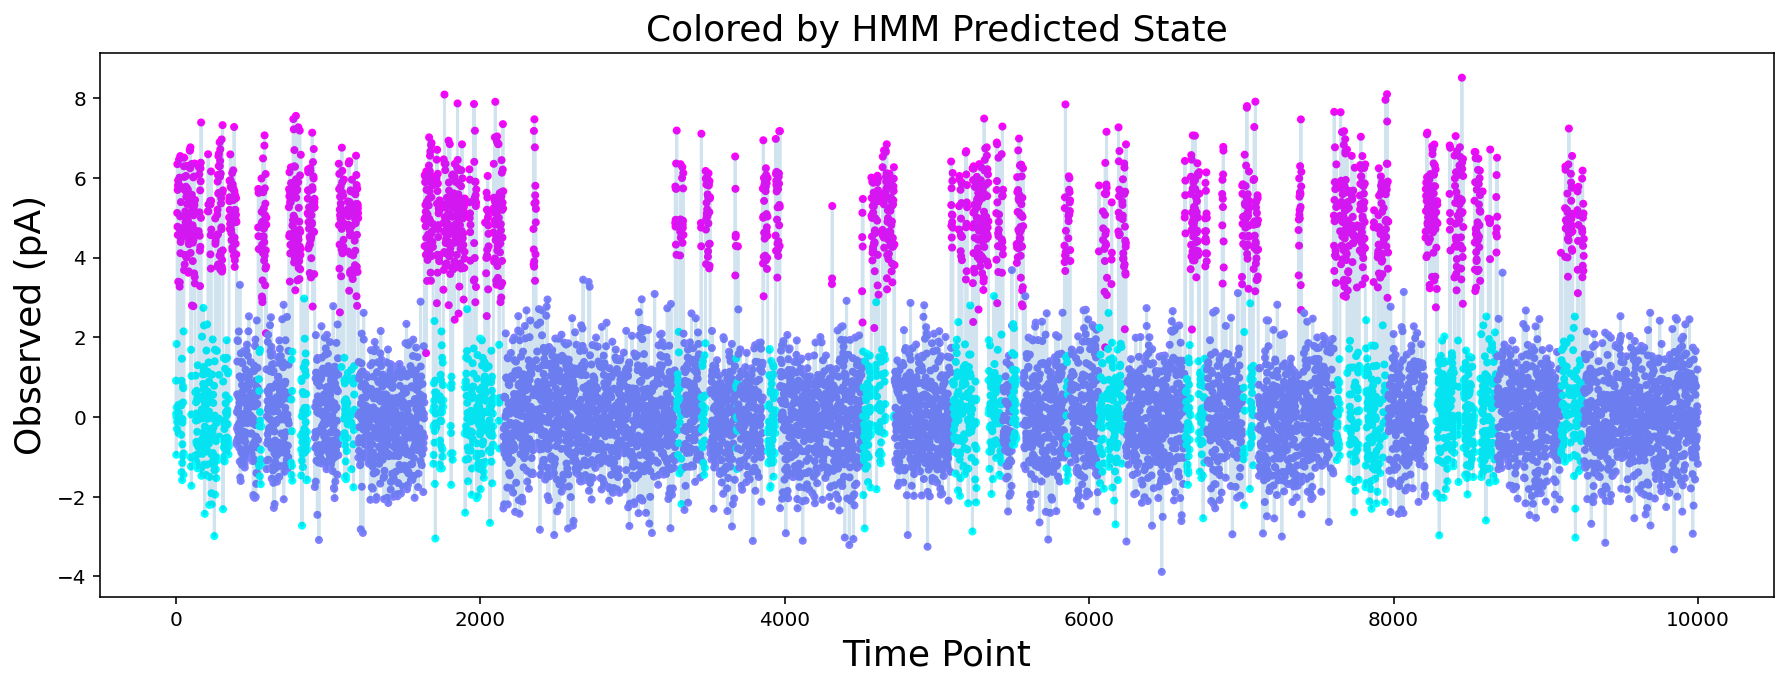

In [75]:
n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State');

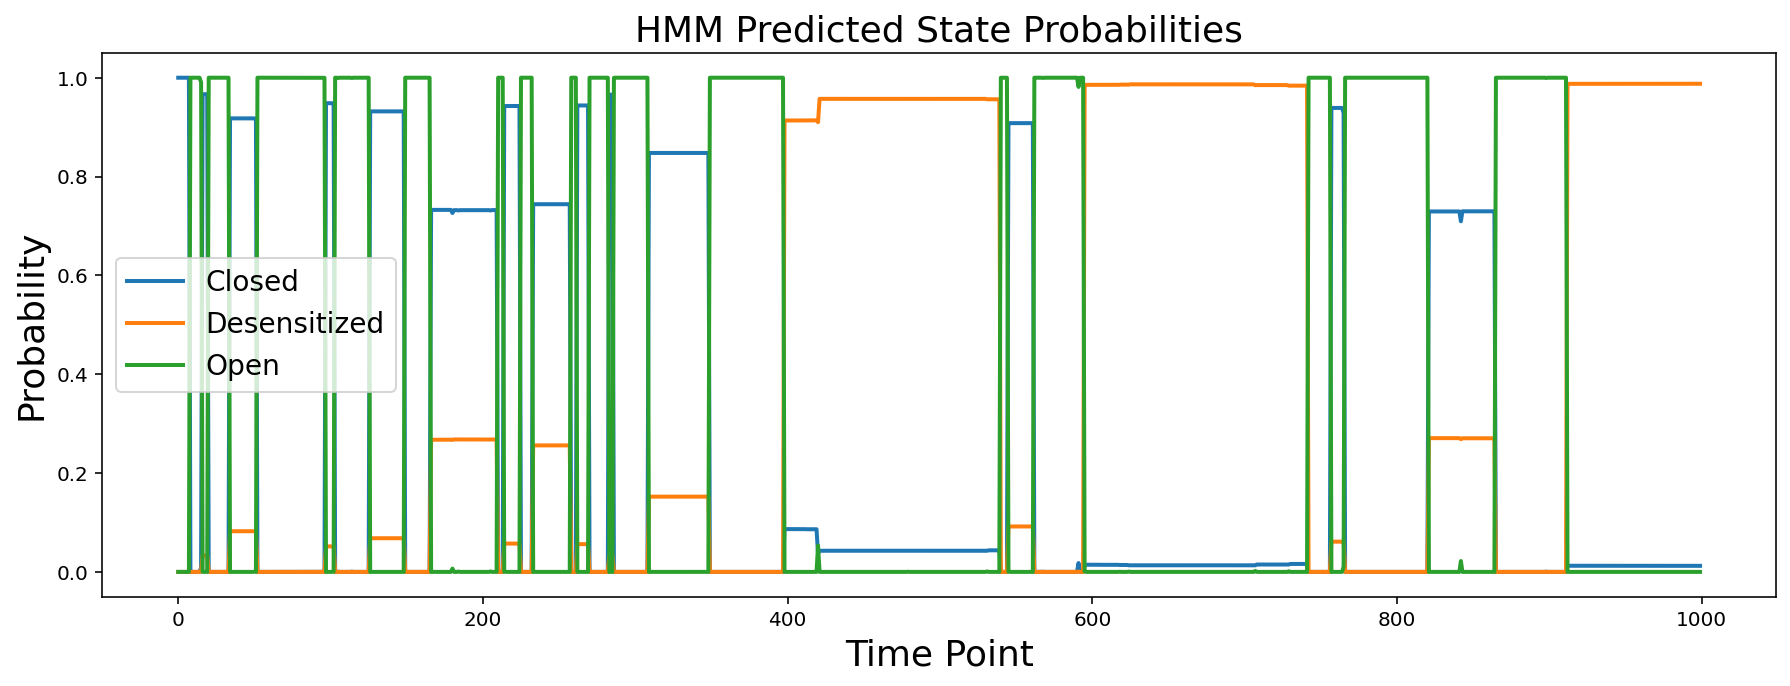

In [77]:
predictedStateProb = hmm.predict_proba(current_pA)

n = 1000
plt.plot(predictedStateProb[:n], lw=2)
plt.xlabel('Time Point')
plt.ylabel('Probability')
plt.title('HMM Predicted State Probabilities')
plt.legend(hmmStateNames[:3]);